# Denoising Diffusion Probabilistic Models with MedNIST Dataset Bundle 

This notebook discusses and uses the MONAI bundle it's included in for generating images from the MedNIST dataset using diffusion models. This i based off the 2d_ddpm_tutorial_ignite.ipynb notebook with a few changes.

First thing to do is import libraries then download the MedNIST dataset:

In [1]:
import os
import shutil
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import monai
import numpy as np
import torch
from monai.bundle import ConfigParser

# path to the bundle directory, this assumes you're running the notebook in its directory
bundle_root = str(Path(".").absolute().parent)

monai.config.print_config()

MONAI version: 1.1.0+45.g1a018a7b
Numpy version: 1.21.5
Pytorch version: 1.12.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 1a018a7b3034a86360d999a6bcc796bad330bba4
MONAI __file__: /home/localek10/workspace/monai/MONAI_mine/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
ITK version: 5.2.1
Nibabel version: 4.0.2
scikit-image version: 0.19.2
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.5.1
TorchVision version: 0.13.1
tqdm version: 4.64.0
lmdb version: 1.2.1
psutil version: 5.9.0
pandas version: 1.4.3
einops version: 0.6.0
transformers version: 4.18.0
mlflow version: 1.28.0
pynrrd version: 0.4.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
dataset_dir = tempfile.mkdtemp() if directory is None else directory
print(dataset_dir)

/tmp/tmpw33bol9_


A bundle can be run on the command line using the Fire library or by parsing the configuration manually then getting parsed content objects. The following is the command to train the network for the default number of epochs. It will state values in the config files which need to be set for a particular run, such as the dataset directory created above, and setting the PYTHONPATH variable. The configuration for this bundle is split into 4 yaml files, one having common definitions for training and inference, one to enable multi-GPU training, and one each for training and inference. Their combinations determine what your final configuration is, in this case the common and train files produce a training script. 

In [ ]:
configs=f"['{bundle_root}/configs/common.yaml','{bundle_root}/configs/train.yaml']"

!PYTHONPATH={bundle_root} python -m monai.bundle run training \
    --meta_file {bundle_root}/configs/metadata.json \
    --config_file "{configs}" \
    --logging_file {bundle_root}/configs/logging.conf \
    --bundle_root {bundle_root} \
    --dataset_dir {dataset_dir}

The test inference script can be invoked as such to produce an output saved tensor with a randomly generated image:

2023-02-16 15:42:37,882 - INFO - --- input summary of monai.bundle.scripts.run ---
2023-02-16 15:42:37,882 - INFO - > runner_id: 'testing'
2023-02-16 15:42:37,883 - INFO - > meta_file: '/home/localek10/workspace/monai/GenerativeModels/model-zoo/models/mednist_ddpm/bundle/configs/metadata.json'
2023-02-16 15:42:37,883 - INFO - > config_file: ['/home/localek10/workspace/monai/GenerativeModels/model-zoo/models/mednist_ddpm/bundle/configs/common.yaml',
 '/home/localek10/workspace/monai/GenerativeModels/model-zoo/models/mednist_ddpm/bundle/configs/infer.yaml']
2023-02-16 15:42:37,883 - INFO - > ckpt_path: './results/output_230215_174009/model_final_iteration=75000.pt'
2023-02-16 15:42:37,883 - INFO - > bundle_root: '/home/localek10/workspace/monai/GenerativeModels/model-zoo/models/mednist_ddpm/bundle'
2023-02-16 15:42:37,883 - INFO - > out_file: 'test.pt'
2023-02-16 15:42:37,883 - INFO - ---


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.44it/s]
[[[], []], null]


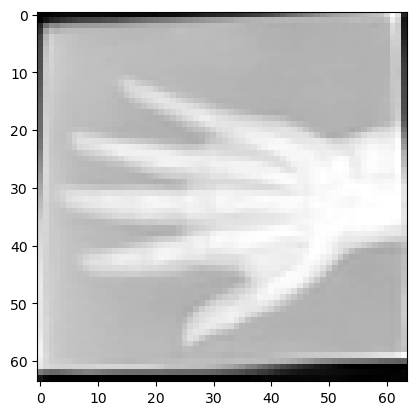

In [25]:
configs=f"['{bundle_root}/configs/common.yaml','{bundle_root}/configs/infer.yaml']"

!PYTHONPATH={bundle_root} python -m monai.bundle run testing \
    --meta_file {bundle_root}/configs/metadata.json \
    --config_file "{configs}" \
    --ckpt_path ./results/output_230215_174009/model_final_iteration=75000.pt \
    --bundle_root {bundle_root} \
    --out_file test.pt

test = torch.load("test.pt", map_location="cpu")

plt.imshow(test[0, 0], vmin=0, vmax=1, cmap="gray")

The same can be done by creating the parser object, filling in its configuration, then resolving the Python objects from the constructed bundle data:

100%|██████████| 1000/1000 [00:09<00:00, 101.06it/s]


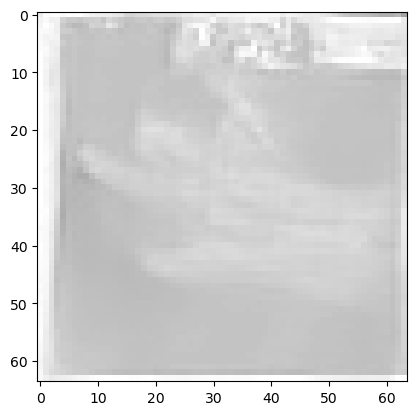

In [24]:
import sys

sys.path.append(bundle_root)

# configure the parser from the bundle's information
cp = ConfigParser()
cp.read_meta(f"{bundle_root}/configs/metadata.json")
cp.read_config([f"{bundle_root}/configs/common.yaml", f"{bundle_root}/configs/infer.yaml"])
cp["bundle_root"] = bundle_root
cp["ckpt_path"] = "./results/output_230215_174009/model_final_iteration=75000.pt"

cp.get_parsed_content("load_state")  # load the saved state from the checkpoint just be resolving this value

device = cp.get_parsed_content("device")  # device used by the bundle
sample = cp.get_parsed_content("sample")  # test sampling function

image_dim = cp["image_dim"]  # get the stored dimension value, no need to resolve anything

noise = torch.rand(1, 1, image_dim, image_dim).to(device)  # or cp.get_parsed_content("noise")

test = sample(noise)

plt.imshow(test[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")